# Machine Learning the Ising Transition
### Carsten Bauer

In [1]:
const IsingTc = 1/(1/2*log(1+sqrt(2))) # Exact Onsager solution

2.269185314213022

# Monte Carlo simulation

In [2]:
using Printf, Dates

up(neighs, i) = neighs[1, i]
right(neighs, i) = neighs[2, i]
down(neighs, i) = neighs[3, i]
left(neighs, i) = neighs[4, i]

function montecarlo(; L, T)
    # set parameters & initialize
    nsweeps = 10^7
    measure_rate = 5_000
    beta = 1/T
    conf = rand([-1, 1], L, L)
    confs = Matrix{Int64}[] # storing intermediate configurations
    # build nearest neighbor lookup table
    lattice = reshape(1:L^2, (L, L))
    ups     = circshift(lattice, (-1,0))
    rights  = circshift(lattice, (0,-1))
    downs   = circshift(lattice,(1,0))
    lefts   = circshift(lattice,(0,1))
    neighs = vcat(ups[:]',rights[:]',downs[:]',lefts[:]')
    
    start_time = now()
    println("Started: ", Dates.format(start_time, "d.u yyyy HH:MM"))
    
    for i in 1:nsweeps
        # sweep
        for i in eachindex(conf)
            # local update
            ΔE = 2.0 * conf[i] * (conf[up(neighs, i)] + conf[right(neighs, i)] +
                                + conf[down(neighs, i)] + conf[left(neighs, i)])
            # Metropolis
            if ΔE <= 0 || rand() < exp(- beta*ΔE)
                conf[i] *= -1 # flip spin
            end
        end
        
        # measure
        iszero(mod(i, measure_rate)) && push!(confs, copy(conf))
    end
    
    end_time = now()
    println("Ended: ", Dates.format(end_time, "d.u yyyy HH:MM"))
    @printf("Duration: %.2f minutes", (end_time - start_time).value / 1000. /60.)
    return confs
end

montecarlo (generic function with 1 method)

In [3]:
montecarlo(L=8, T=5)

Started: 5.Aug 2019 11:38
Ended: 5.Aug 2019 11:39
Duration: 0.25 minutes

2000-element Array{Array{Int64,2},1}:
 [-1 1 … -1 1; -1 -1 … 1 -1; … ; 1 -1 … -1 1; 1 -1 … -1 1]  
 [-1 -1 … 1 1; -1 -1 … 1 -1; … ; -1 -1 … -1 -1; 1 1 … 1 1]  
 [-1 -1 … 1 1; 1 -1 … 1 -1; … ; 1 1 … 1 -1; 1 -1 … -1 -1]   
 [-1 -1 … 1 -1; 1 -1 … 1 1; … ; -1 -1 … -1 -1; -1 -1 … 1 1] 
 [-1 -1 … -1 -1; -1 1 … 1 -1; … ; -1 1 … -1 1; 1 -1 … -1 1] 
 [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 -1; 1 1 … -1 1]         
 [-1 -1 … -1 1; 1 1 … 1 1; … ; -1 -1 … 1 -1; -1 -1 … -1 -1] 
 [-1 -1 … 1 1; 1 -1 … 1 1; … ; -1 -1 … -1 -1; -1 -1 … 1 -1] 
 [1 -1 … 1 -1; -1 -1 … 1 -1; … ; -1 -1 … 1 -1; -1 -1 … -1 1]
 [1 1 … -1 -1; 1 -1 … -1 -1; … ; 1 -1 … -1 1; 1 1 … -1 1]   
 [1 1 … 1 1; -1 1 … -1 -1; … ; -1 1 … -1 -1; 1 1 … -1 1]    
 [1 1 … 1 1; 1 1 … -1 -1; … ; 1 1 … 1 1; 1 1 … 1 1]         
 [1 1 … -1 -1; -1 -1 … 1 1; … ; -1 -1 … -1 -1; 1 -1 … 1 1]  
 ⋮                                                          
 [-1 -1 … 1 1; 1 1 … 1 1; … ; -1 -1 … -1 -1; -1 -1 … -1 1]  
 [-1 1 … -1 -1; 1 1 … -1 -1; … ; -1 1 … -1 -1; 

### Simulate an $L=8$ system at a couple of temperatures

In [4]:
Ts = [1.189, 1.733, 2.069, 2.269, 2.278, 2.469, 2.822, 3.367]

8-element Array{Float64,1}:
 1.189
 1.733
 2.069
 2.269
 2.278
 2.469
 2.822
 3.367

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


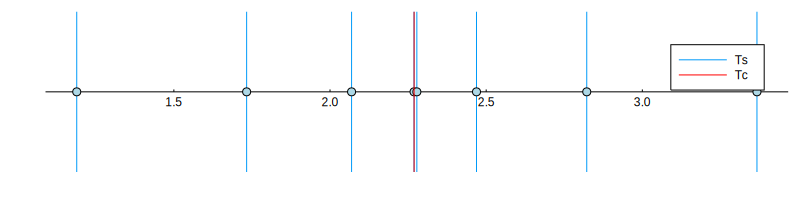

In [5]:
# visualize temperatures
using Plots
vline(Ts, grid=false, axis=:x, framestyle=:origin, xlim=(minimum(Ts)-0.1, maximum(Ts)+0.1), size=(800,200), label="Ts")
scatter!(Ts, fill(0, length(Ts)), color=:lightblue, label="")
vline!([IsingTc], color=:red, label="Tc")

In [6]:
confs = Dict{Float64, Array{Float64,3}}() # key: T, value: confs
for T in Ts
    println("T = $T"); flush(stdout);
    c = montecarlo(L=8, T=T)
    confs[T] = cat(c..., dims=3)
    println("Done.\n")
end

T = 1.189
Started: 5.Aug 2019 11:39
Ended: 5.Aug 2019 11:40
Duration: 0.29 minutesDone.

T = 1.733
Started: 5.Aug 2019 11:40
Ended: 5.Aug 2019 11:40
Duration: 0.29 minutesDone.

T = 2.069
Started: 5.Aug 2019 11:40
Ended: 5.Aug 2019 11:40
Duration: 0.30 minutesDone.

T = 2.269
Started: 5.Aug 2019 11:40
Ended: 5.Aug 2019 11:41
Duration: 0.29 minutesDone.

T = 2.278
Started: 5.Aug 2019 11:41
Ended: 5.Aug 2019 11:41
Duration: 0.28 minutesDone.

T = 2.469
Started: 5.Aug 2019 11:41
Ended: 5.Aug 2019 11:41
Duration: 0.27 minutesDone.

T = 2.822
Started: 5.Aug 2019 11:41
Ended: 5.Aug 2019 11:42
Duration: 0.26 minutesDone.

T = 3.367
Started: 5.Aug 2019 11:42
Ended: 5.Aug 2019 11:42
Duration: 0.27 minutesDone.



# Machine learning the magnetic phase transition

In [7]:
using Flux
using Flux: crossentropy, onecold, onehotbatch, params, throttle, @epochs
using Statistics, Random

┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\Flux\QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1184


In [8]:
function flatten_and_Z2(confs, T)
    c = confs[T]
    cs = Float64.(reshape(c, (64,:))) # flatten space dimension
    cs = hcat(cs, -one(eltype(cs)) .* cs) # concatenate Z2 (spin flip) symmetry partners
    return cs
end

flatten_and_Z2 (generic function with 1 method)

In [9]:
L = 8
Tleft = 1.189
Tright = 3.367

confs_left = flatten_and_Z2(confs, Tleft)
confs_right = flatten_and_Z2(confs, Tright);

In [10]:
# visualize configurations
printconfs(confs) = plot([heatmap(Gray.(reshape(confs[:,i], (L,L))), ticks=false) for i in 1:100:size(confs, 2)]...)

printconfs (generic function with 1 method)

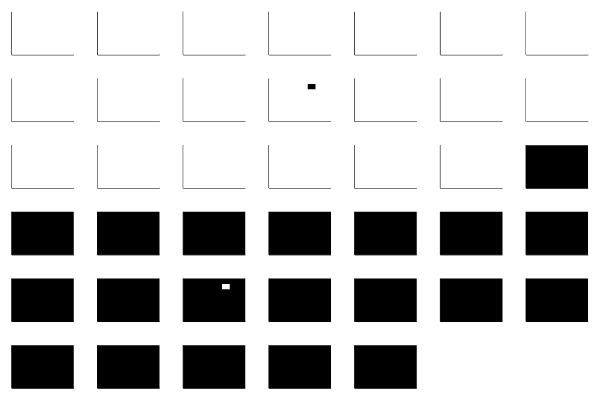

In [11]:
printconfs(confs_left)

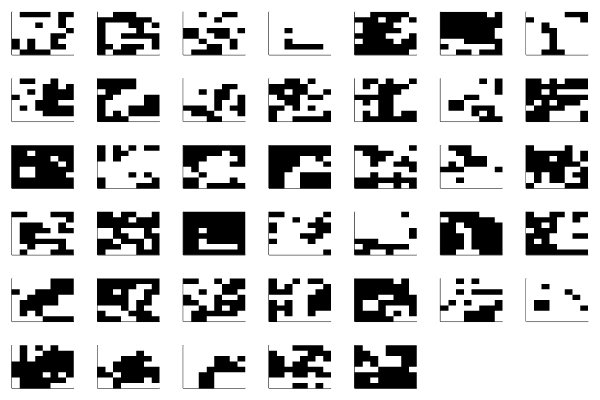

In [12]:
printconfs(confs_right)

In [13]:
# set up as training data
neach = size(confs_left, 2)
X = hcat(confs_left, confs_right)
labels = vcat(fill(1, neach), fill(0, neach))
Y = onehotbatch(labels, 0:1)
dataset = Base.Iterators.repeated((X, Y), 10); # repeat dataset 10 times

In [14]:
# create neural network with 10 hidden units and 2 output neurons
Random.seed!(123)

m = Chain(
    Dense(L^2, 10, relu),
    Dense(10, 2),
    softmax)

Chain(Dense(64, 10, NNlib.relu), Dense(10, 2), NNlib.softmax)

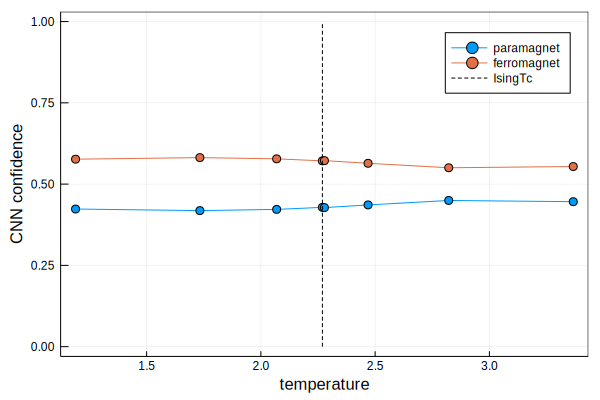

In [15]:
# classify phases at all intermediate temperatures
function confidence_plot()
    results = Dict{Float64, Vector{Float32}}()
    for T in Ts
      c = flatten_and_Z2(confs, T);
      results[T] = vec(mean(m(c), dims=2).data)
    end
    results = sort(results)

    p = plot(keys(results) |> collect, reduce(hcat, values(results))',
      marker=:circle,
      xlab="temperature",
      ylabel="CNN confidence",
      labels=["paramagnet", "ferromagnet"],
      frame=:box)
    plot!(p, [IsingTc, IsingTc], [0, 1], ls=:dash, color=:black, label="IsingTc")
    if (@isdefined IJulia)
        # "animation" in jupyter
        IJulia.clear_output(true)
    end
    display(p)
end

confidence_plot()

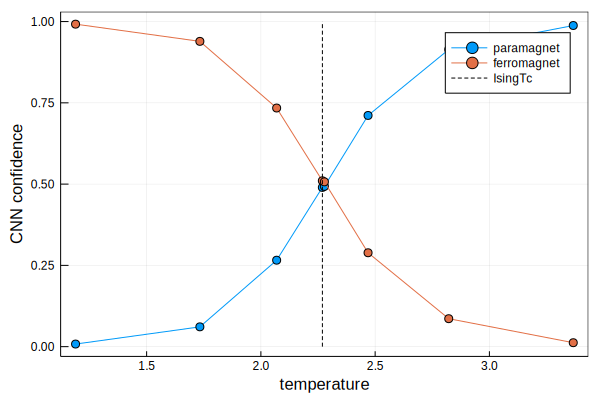

In [16]:
# define cost-function
loss(x, y) = crossentropy(m(x), y)

# define optimizer
opt = ADAM()

# train for 100 epochs
for i in 1:100
    Flux.train!(loss, params(m), dataset, opt)
end

# 
confidence_plot()

In Jupyter notebooks or Juno you should see an "animation" of the confidence plot across training.

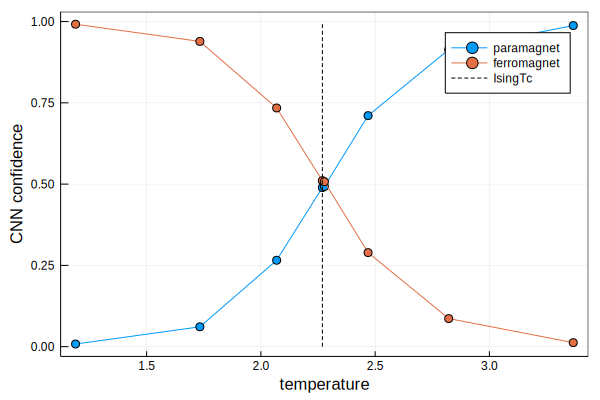

In [17]:
# Define a callback
evalcb = () -> begin
#     @show(loss(X, Y))
#     @show(accuracy(X, Y))
    confidence_plot()
end

# Reset the network and the optimizer
Random.seed!(123)
m = Chain(
    Dense(L^2, 10, relu),
    Dense(10, 2),
    softmax)
opt = ADAM()

# Train for 100 epochs (with "animation")
for i in 1:100
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 50))
end